In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('Mage_combo_30_oct.csv', index_col=0)

CELL_LINES = ['k562', 'el4']

# lowercase the columns for ease of processing
df.columns = [col.lower() for col in df.columns]

df

,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_magea3,hamming_distance_from_titin,af3_ranking_scores,mw,weight,ul exact,c exact if 477,r1_k562,r2_k562,r3_k562,r1_el4,r2_el4,r3_el4
mage_p2_titin,ESDPIVAQY,titin_wt,NaN,titin,5.025015,4.0,0.0,0.983471,1021.09,0.5,489.672801,1.026568,41.555686,42.433795,43.405351,3.573628,4.372790,4.392098
mage_p3,EVDPVGLLF,so3_convnet_noise=0p5__fixed_E1,fixed_structure,magea3,5.198635,3.0,6.0,1.036476,988.15,0.5,505.996053,1.060788,28.398262,22.043226,25.519417,0.878866,1.132701,0.855888
mage_p4,YLDPLQPEY,so3_convnet_noise=0p5,sim_anneal,magea3,5.196480,6.0,6.0,1.078432,1137.26,0.5,439.653202,0.921705,27.727075,29.433227,25.115109,0.507988,1.117083,0.618809
mage_p5,ELDLIPLTY,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,5.194169,5.0,5.0,1.167458,1076.26,0.5,464.571758,0.973945,16.821289,16.721479,15.666947,0.455669,0.442166,0.675615
mage_p6,MTDPIGQDF,so3_convnet_base_ensemble,fixed_structure,magea3,5.193401,5.0,6.0,1.005794,1023.13,0.5,488.696451,1.024521,19.386561,17.332967,17.059366,0.546125,0.594933,0.864605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mage_p93,YLDPIPLAY,so3_convnet_base_ensemble,sim_anneal,magea3,4.930145,5.0,5.0,1.059747,1064.25,0.5,469.814423,0.984936,20.386181,20.972637,19.706437,0.629081,0.858322,0.697556
mage_p94,YTDPIEDTF,so3_convnet_noise=0p5,fixed_structure,titin,4.929909,6.0,6.0,1.045234,1100.15,0.5,454.483479,0.952796,28.258978,35.428555,36.732154,0.597267,0.699770,0.711738
mage_p95,QSDPIESEY,so3_convnet_base_ensemble,fixed_structure,titin,4.922758,5.0,4.0,1.053901,1067.07,0.5,468.572821,0.982333,41.582055,49.523088,43.175452,7.090031,6.512232,5.031232
mage_p1_wt,EVDPIGHLY,magea3_wt,NaN,magea3,5.208200,0.0,4.0,0.999842,1042.16,0.5,479.772780,1.005813,36.443553,37.700439,31.196724,1.851380,2.269052,1.615178


In [2]:
# compute and store cutoffs, control values, as well as response columns to be put on the dataframe

cell_line_to_cutoff = {}
# have to manually do it because pandas breaks downfor some reason if I then try to drop the unstim row, and try to use the unstim values
cell_line_to_control = {
    'k562': [18.621148, 23.846675, 21.820866],
    'el4': [0.475935, 0.534058, 0.334536]
}
cell_line_to_wt_scores = {}
cell_line_to_ylim = {
    'k562': (0.5, 2),
    'el4': (-1, 1.5)
}
for cl in CELL_LINES:
    cell_line_to_cutoff[cl] = df.loc['unstim', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].mean() + df.loc['unstim', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].std() * 3

    df[f'resp_{cl}'] = [True if elem > cell_line_to_cutoff[cl] else False for elem in df[[f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].mean(axis=1)]

    score_wt_1 = df.loc[df['model'] == 'magea3_wt', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].values[0]
    score_wt_2 = df.loc[df['model'] == 'titin_wt', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].values[0]
    cell_line_to_wt_scores[cl] = (score_wt_1, score_wt_2)

df['resp'] = df['resp_k562'] | df['resp_el4']

df.drop(['unstim', 'mage_p1_wt', 'mage_p2_titin'], inplace=True)

df


,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_magea3,hamming_distance_from_titin,af3_ranking_scores,mw,weight,...,c exact if 477,r1_k562,r2_k562,r3_k562,r1_el4,r2_el4,r3_el4,resp_k562,resp_el4,resp
mage_p3,EVDPVGLLF,so3_convnet_noise=0p5__fixed_E1,fixed_structure,magea3,5.198635,3.0,6.0,1.036476,988.15,0.5,...,1.060788,28.398262,22.043226,25.519417,0.878866,1.132701,0.855888,False,True,True
mage_p4,YLDPLQPEY,so3_convnet_noise=0p5,sim_anneal,magea3,5.196480,6.0,6.0,1.078432,1137.26,0.5,...,0.921705,27.727075,29.433227,25.115109,0.507988,1.117083,0.618809,False,False,False
mage_p5,ELDLIPLTY,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,5.194169,5.0,5.0,1.167458,1076.26,0.5,...,0.973945,16.821289,16.721479,15.666947,0.455669,0.442166,0.675615,False,False,False
mage_p6,MTDPIGQDF,so3_convnet_base_ensemble,fixed_structure,magea3,5.193401,5.0,6.0,1.005794,1023.13,0.5,...,1.024521,19.386561,17.332967,17.059366,0.546125,0.594933,0.864605,False,False,False
mage_p7,HQDPIGLKY,so3_convnet_noise=0p5,fixed_structure,magea3,5.193282,4.0,5.0,1.057895,1070.22,0.5,...,0.979442,21.161467,17.601681,16.674007,0.566111,0.478189,0.423317,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mage_p91,ELDPIPLGF,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,4.931764,5.0,5.0,1.008377,1000.16,0.5,...,1.048050,25.943931,29.955716,27.814319,1.440270,3.068014,0.957654,False,True,True
mage_p92,ESDPIEDEY,so3_convnet_base_ensemble,fixed_structure,titin,4.930344,4.0,3.0,1.050419,1096.07,0.5,...,0.956342,47.117365,46.087487,43.239838,8.132715,10.077263,8.931099,True,True,True
mage_p93,YLDPIPLAY,so3_convnet_base_ensemble,sim_anneal,magea3,4.930145,5.0,5.0,1.059747,1064.25,0.5,...,0.984936,20.386181,20.972637,19.706437,0.629081,0.858322,0.697556,False,False,False
mage_p94,YTDPIEDTF,so3_convnet_noise=0p5,fixed_structure,titin,4.929909,6.0,6.0,1.045234,1100.15,0.5,...,0.952796,28.258978,35.428555,36.732154,0.597267,0.699770,0.711738,True,False,True


In [3]:


resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}
model_to_marker = {'magea3_wt': 'X', 'titin_wt': 'X',
                   'so3_convnet_base_ensemble__fixed_structure': 's',
                   'so3_convnet_noise=0p5__fixed_structure': 'd',
                   'so3_convnet_base_ensemble__sim_anneal': '<',
                   'so3_convnet_noise=0p5__sim_anneal': '>',
                   'so3_convnet_base_ensemble__fixed_E1__sim_anneal': '^',
                   'so3_convnet_base_ensemble__fixed_E1__fixed_structure': 'v',
                   'so3_convnet_noise=0p5__fixed_E1__sim_anneal': 'o',
                   'so3_convnet_noise=0p5__fixed_E1__fixed_structure': 'O',}

models = list(model_to_marker.keys())

def get_model_mask(df, model_and_method):
    if len(model_and_method.split('__')) == 1:
        return df['model'] == model_and_method
    elif len(model_and_method.split('__')) == 2:
        return (df['model'] == model_and_method.split('__')[0]) & (df['sampling_method'] == model_and_method.split('__')[1])
    elif len(model_and_method.split('__')) == 3:
        return (df['model'] == '__'.join([model_and_method.split('__')[0], model_and_method.split('__')[1]])) & (df['sampling_method'] == model_and_method.split('__')[2])
    else:
        raise ValueError('model_and_method must have at most one "__"')

df['min_hamming_distance_from_struc'] = np.min(df[['hamming_distances_from_magea3', 'hamming_distance_from_titin']], axis=1)

hamming_distance_from_resp_struc = []
for i, row in df.iterrows():
    if row["wt_for_design"] == 'magea3':
        hamming_distance_from_resp_struc.append(row['hamming_distances_from_magea3'])
    elif row["wt_for_design"] == 'titin':
        hamming_distance_from_resp_struc.append(row['hamming_distance_from_titin'])
df['hamming_distance_from_resp_struc'] = hamming_distance_from_resp_struc

df

,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_magea3,hamming_distance_from_titin,af3_ranking_scores,mw,weight,...,r2_k562,r3_k562,r1_el4,r2_el4,r3_el4,resp_k562,resp_el4,resp,min_hamming_distance_from_struc,hamming_distance_from_resp_struc
mage_p3,EVDPVGLLF,so3_convnet_noise=0p5__fixed_E1,fixed_structure,magea3,5.198635,3.0,6.0,1.036476,988.15,0.5,...,22.043226,25.519417,0.878866,1.132701,0.855888,False,True,True,3.0,3.0
mage_p4,YLDPLQPEY,so3_convnet_noise=0p5,sim_anneal,magea3,5.196480,6.0,6.0,1.078432,1137.26,0.5,...,29.433227,25.115109,0.507988,1.117083,0.618809,False,False,False,6.0,6.0
mage_p5,ELDLIPLTY,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,5.194169,5.0,5.0,1.167458,1076.26,0.5,...,16.721479,15.666947,0.455669,0.442166,0.675615,False,False,False,5.0,5.0
mage_p6,MTDPIGQDF,so3_convnet_base_ensemble,fixed_structure,magea3,5.193401,5.0,6.0,1.005794,1023.13,0.5,...,17.332967,17.059366,0.546125,0.594933,0.864605,False,False,False,5.0,5.0
mage_p7,HQDPIGLKY,so3_convnet_noise=0p5,fixed_structure,magea3,5.193282,4.0,5.0,1.057895,1070.22,0.5,...,17.601681,16.674007,0.566111,0.478189,0.423317,False,False,False,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mage_p91,ELDPIPLGF,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,4.931764,5.0,5.0,1.008377,1000.16,0.5,...,29.955716,27.814319,1.440270,3.068014,0.957654,False,True,True,5.0,5.0
mage_p92,ESDPIEDEY,so3_convnet_base_ensemble,fixed_structure,titin,4.930344,4.0,3.0,1.050419,1096.07,0.5,...,46.087487,43.239838,8.132715,10.077263,8.931099,True,True,True,3.0,3.0
mage_p93,YLDPIPLAY,so3_convnet_base_ensemble,sim_anneal,magea3,4.930145,5.0,5.0,1.059747,1064.25,0.5,...,20.972637,19.706437,0.629081,0.858322,0.697556,False,False,False,5.0,5.0
mage_p94,YTDPIEDTF,so3_convnet_noise=0p5,fixed_structure,titin,4.929909,6.0,6.0,1.045234,1100.15,0.5,...,35.428555,36.732154,0.597267,0.699770,0.711738,True,False,True,6.0,6.0


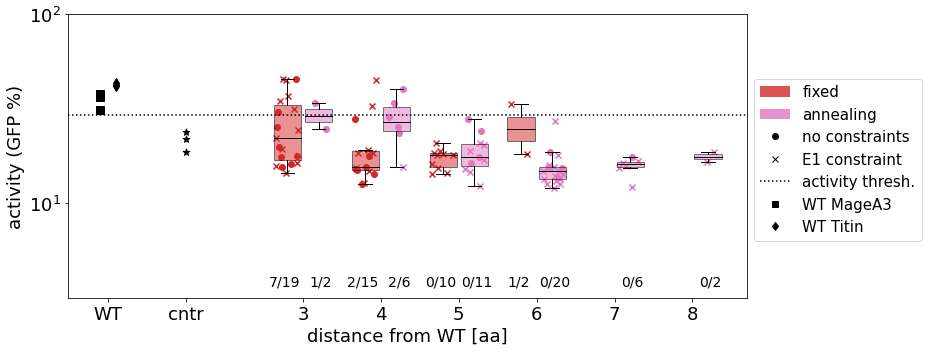

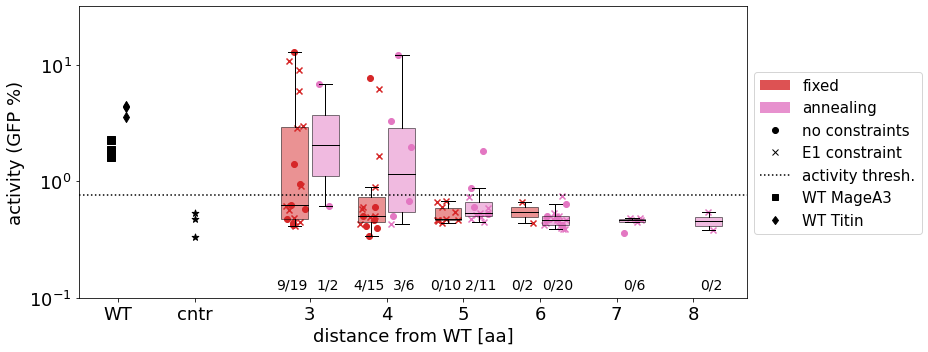

In [4]:
def make_barplot_single_cell_line(df, cl):

    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    fontsize = 18

    # make a barplot of success over distance from wildtype for the 4 model classes
    model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__fixed_E1__fixed_structure', 'so3_convnet_noise=0p5__fixed_E1__fixed_structure'),
                    ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal', 'so3_convnet_base_ensemble__fixed_E1__sim_anneal', 'so3_convnet_noise=0p5__fixed_E1__sim_anneal')]
    model_group_names = ['fixed', 'annealing']
    colors = ['tab:red', 'tab:pink']

    plt.figure(figsize=(13, 5))
    ax = plt.gca()

    df_here = df.copy()

    all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))

    for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
        masks = [get_model_mask(df_here, model) for model in model_group]
        mask = np.logical_or.reduce(masks)
        curr_df = df_here[mask]
        distances = curr_df['min_hamming_distance_from_struc'].values
        responses = curr_df[f'resp_{cl}'].values

        distance_to_resp = {}
        distance_to_exp_score = {}
        distance_to_mean_exp_score = {}
        distance_to_is_e1 = {}
        for distance in np.unique(distances):
            dist_mask = distances == distance
            distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
            distance_to_exp_score[distance] = np.vstack([curr_df[dist_mask][f'r1_{cl}'],
                                                            curr_df[dist_mask][f'r2_{cl}'],
                                                            curr_df[dist_mask][f'r3_{cl}']])
            distance_to_mean_exp_score[distance] = np.mean(distance_to_exp_score[distance], axis=0)
            distance_to_is_e1[distance] = curr_df[dist_mask]['model'].str.contains('fixed_E1').values
        
        distances = list(distance_to_exp_score.keys())
        scores = [np.log10(distance_to_exp_score[distance]) for distance in distances]
        mean_scores = [np.log10(distance_to_mean_exp_score[distance]) for distance in distances]
        is_e1_list = [distance_to_is_e1[distance] for distance in distances]

        positions = [distance - 0.2 + i*0.4 for distance in distances]

        ax.boxplot(mean_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

        k = 0
        for position, scores_in_distance, is_e1 in zip(positions, mean_scores, is_e1_list):
            if len(scores_in_distance.shape) == 2:
                scores_in_distance = scores_in_distance.T

            for val in [True, False]:

                if val:
                    is_e1_mask = is_e1
                    marker = 'o'
                else:
                    is_e1_mask = ~is_e1
                    marker = 'x'

                for item in scores_in_distance[is_e1_mask]:
                    noise = np.random.uniform(-0.15, 0.15)
                    len_item = len(item) if isinstance(item, np.ndarray) else 1
                    if k == 0:
                        ax.scatter([position+noise]*len_item, item, color=color, marker=marker, label=model_group_name)
                        # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
                    else:
                        ax.scatter([position+noise]*len_item, item, color=color, marker=marker)
                        # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
                    k += 1

        # put number of examples under each boxplot
        ax.set_ylim(*cell_line_to_ylim[cl])
        for position, distance, scores_in_distance in zip(positions, distances, mean_scores):
            offset = 0.03 if i == 1 else -0.03
            ax.text(position+offset, cell_line_to_ylim[cl][0]+0.05, f'{int(distance_to_resp[distance][True])}/{len(scores_in_distance)}', ha='center', va='bottom', fontsize=fontsize-4)


    min_distance = min(all_distances)
    wt_xtick = min_distance - 2.5
    control_xtick = wt_xtick + 1

    ax.scatter([wt_xtick-0.1]*len(cell_line_to_wt_scores[cl][0]), np.log10(cell_line_to_wt_scores[cl][0]), color='black', marker='s', s=50)
    ax.scatter([wt_xtick+0.1]*len(cell_line_to_wt_scores[cl][1]), np.log10(cell_line_to_wt_scores[cl][1]), color='black', marker='d', s=50)
    ax.scatter([control_xtick]*len(cell_line_to_control[cl]), np.log10(cell_line_to_control[cl]), color='black', marker='*', s=50)

    ax.axhline(np.log10(cell_line_to_cutoff[cl]), color='black', linestyle=':', label='activity thresh.')

    xticks = [wt_xtick, control_xtick] + list(all_distances)
    xticklabels = ['WT', 'cntr'] + [str(int(distance)) for distance in all_distances]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    # keep only major y tick labels that are integers
    ticks_to_keep = [tick for tick in ax.get_yticks() if tick.is_integer()]
    ax.set_yticks(ticks_to_keep)
    
    ax.set_yticklabels(['$10^{}$'.format('{' + str(int(y)) + '}') for y in ax.get_yticks()])

    ax.tick_params(axis='both', labelsize=fontsize)


    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
    ax.set_ylabel('activity (GFP %)', fontsize=fontsize)

    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    # put legend outside of figure on the right

    legend_handles = [Patch(facecolor='tab:red', alpha=0.8, label='fixed'),
                      Patch(facecolor='tab:pink', alpha=0.8, label='annealing'),
                      Line2D([0], [0], color='black', marker='o', linestyle='None', label='no constraints'),
                      Line2D([0], [0], color='black', marker='x', linestyle='None', label='E1 constraint'),
                      Line2D([0], [0], color='black', linestyle=':', label='activity thresh.'),
                      Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT MageA3'),
                      Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT Titin')]

    ax.legend(handles=legend_handles, fontsize=fontsize-3, bbox_to_anchor=(1, 0.8))

    plt.tight_layout()
    # plt.savefig('__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt.png')
    # plt.savefig('__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt.pdf')
    plt.show()


make_barplot_single_cell_line(df, 'k562')
make_barplot_single_cell_line(df, 'el4')

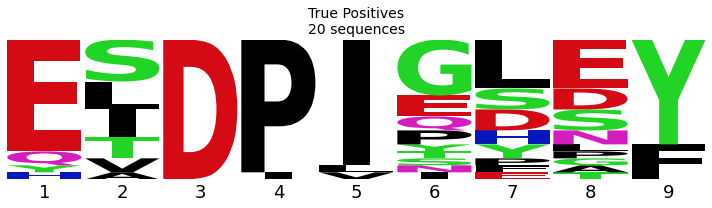

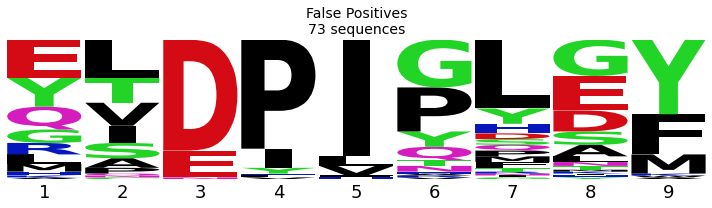

In [5]:
# 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# write the number of sequences in each logoplot

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
import logomaker

# true and tcrdock pae below 5.5
df_true_below = df[(df['tcrdock_pae'] < 5.5) & (df['resp'] == True)]
df_false_below = df[(df['tcrdock_pae'] < 5.5) & (df['resp'] == False)]

len_seq = len(df_true_below['sequence'].values[0])

for title, df_ in zip(['True Positives', 'False Positives'],
                      [df_true_below, df_false_below]):

    plt.figure(figsize=(10, 3))

    # get sequences, make pwm
    seqs = df_['sequence']
    pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
    for seq in seqs:
        assert len(seq) == len_seq
        for i, aa in enumerate(seq):
            pwm[i, AMINO_ACIDS.index(aa)] += 1
    pwm = pwm / pwm.sum(axis=1)[:, None]
    pwm[np.isnan(pwm)] = 0

    # plot pwm as logoplot
    df_pwm = pd.DataFrame(pwm, columns=AMINO_ACIDS)
    logomaker.Logo(df_pwm, ax=plt.gca())

    plt.title(title + f'\n{len(seqs)} sequences', fontsize=14)

    plt.xticks(np.arange(len_seq), np.arange(len_seq)+1)

    # keep x axis labels, but nothing else pertaiing to the axis
    
    # Hide the y-axis completely
    plt.gca().get_yaxis().set_visible(False)

    # Remove the x-axis horizontal line (spine)
    plt.gca().spines['bottom'].set_visible(False)

    # Remove all the spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Remove y-ticks
    plt.gca().tick_params(axis='y', which='both', length=0)

    # Remove x-tick marks but keep the labels
    plt.gca().tick_params(axis='x', which='both', length=0)

    plt.gca().tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.pdf')
    # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.png')
    plt.show()

/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_1311/2019695529.py:14: RuntimeWarning: invalid value encountered in true_divide
  pwm = pwm / pwm.sum(axis=1)[:, None]
/Users/gianmarcovisani/opt/anaconda3/envs/e3nn-tutorial/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_1311/2019695529.py:14: RuntimeWarning: invalid value encountered in true_divide
  pwm = pwm / pwm.sum(axis=1)[:, None]
/Users/gianmarcovisani/opt/anaconda3/envs/e3nn-tutorial/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


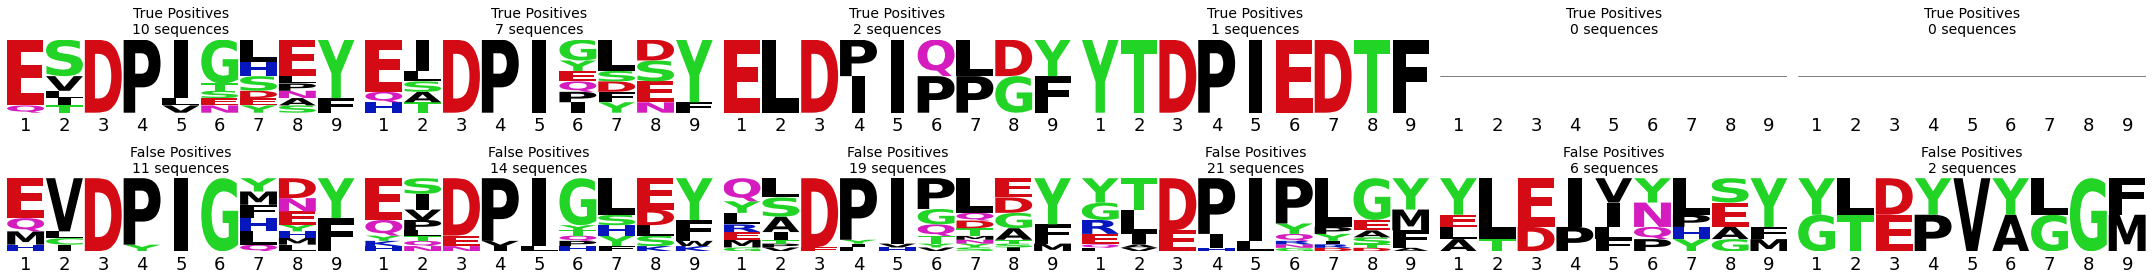

"\nHard to really make sense of this to be honest. the E-DPI---Y motif seems to be pretty preserved, but not necessarily.\nHard to know what's going on among the false positives.\nThere seem to be epistatic interactions going on. That would have to explain the interactions I think.\n"

In [6]:
# 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# write the number of sequences in each logoplot

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
import logomaker

def get_pwm(df_):
    seqs = df_['sequence']
    pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
    for seq in seqs:
        assert len(seq) == len_seq
        for i, aa in enumerate(seq):
            pwm[i, AMINO_ACIDS.index(aa)] += 1
    pwm = pwm / pwm.sum(axis=1)[:, None]
    pwm[np.isnan(pwm)] = 0
    return pwm


len_seq = len(df['sequence'].values[0])

distances = sorted(np.unique(df['min_hamming_distance_from_struc'].values))

nrows = 2
ncols = len(distances)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*2))

for col, distance in enumerate(distances):

    df_true_below = df[(df['tcrdock_pae'] < 5.5) & (df['resp'] == True) & (df['min_hamming_distance_from_struc'] == distance)]
    df_false_below = df[(df['tcrdock_pae'] < 5.5) & (df['resp'] == False) & (df['min_hamming_distance_from_struc'] == distance)]

    # get sequences, make pwm
    pwm_true_below = get_pwm(df_true_below)
    df_pwm_true_below = pd.DataFrame(pwm_true_below, columns=AMINO_ACIDS)
    pwm_false_below = get_pwm(df_false_below)
    df_pwm_false_below = pd.DataFrame(pwm_false_below, columns=AMINO_ACIDS)

    for row, (title, df_, num_seqs) in enumerate(zip(['True Positives', 'False Positives'],
                                                        [df_pwm_true_below, df_pwm_false_below],
                                                        [len(df_true_below), len(df_false_below)])):

        ax = axs[row, col]

        logomaker.Logo(df_, ax=ax)

        ax.set_title(title + f'\n{num_seqs} sequences', fontsize=14)

        ax.set_xticks(np.arange(len_seq), np.arange(len_seq)+1)

        # keep x axis labels, but nothing else pertaiing to the axis
        
        # Hide the y-axis completely
        ax.get_yaxis().set_visible(False)

        # Remove the x-axis horizontal line (spine)
        ax.spines['bottom'].set_visible(False)

        # Remove all the spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Remove y-ticks
        ax.tick_params(axis='y', which='both', length=0)

        # Remove x-tick marks but keep the labels
        ax.tick_params(axis='x', which='both', length=0)

        ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
# plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.pdf')
# plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.png')
plt.show()

'''
Hard to really make sense of this to be honest. the E-DPI---Y motif seems to be pretty preserved, but not necessarily.
Hard to know what's going on among the false positives.
There seem to be epistatic interactions going on. That would have to explain the interactions I think.
'''

<Figure size 432x288 with 0 Axes>

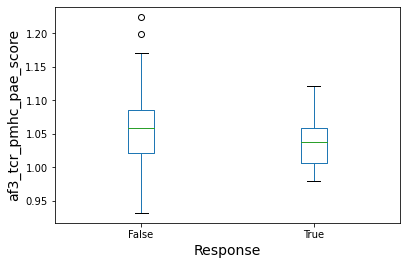

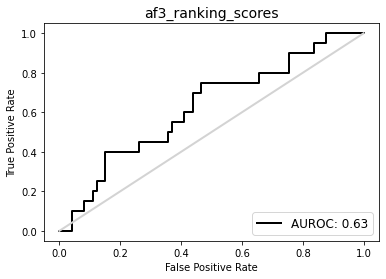

<Figure size 432x288 with 0 Axes>

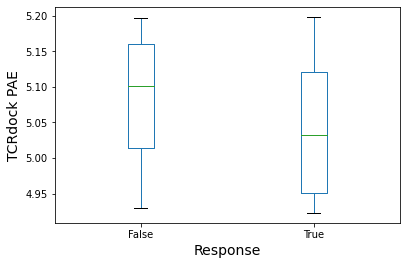

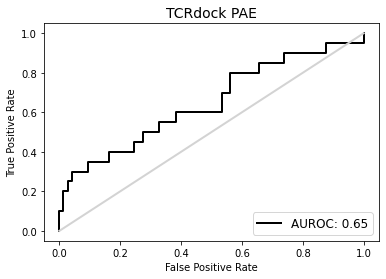

In [8]:
# boxplot with af3_ranking_scores on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='af3_ranking_scores', by='resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('af3_tcr_pmhc_pae_score', fontsize=14)
plt.show()

# roc curve plot and auroc for tcrdock_pae
mask = ~df['af3_ranking_scores'].isna()
fpr, tpr, _ = roc_curve(df['resp'][mask], -df['af3_ranking_scores'][mask])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('af3_ranking_scores', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


# boxplot with tcrdock_pae on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='tcrdock_pae', by='resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('TCRdock PAE', fontsize=14)
plt.show()

# roc curve plot and auroc for tcrdock_pae
fpr, tpr, _ = roc_curve(df['resp'], -df['tcrdock_pae'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TCRdock PAE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()
